In [2]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import deque

In [3]:
# Class Point
class Point:
    def __init__(self, x, y, label=None, color=None ):
        self.x = x
        self.y = y
        self.label = label

        self.color = color
    
    def __str__(self):
        return "Point: (" + str(self.x) + ", " + str(self.y) + ")" + " | " + str(self.label) + " | " + str(self.color)

In [4]:
# Class Colored Vertex (3-color graph coloring)
class Vertex(Point):
    def __init__(self, x, y, color=None, vertex_type=None):
        super().__init__(x, y, color)
        self.vertex_type = vertex_type    
        
    def __str__(self):
        return super().__str__() + " | " + str(self.vertex_type)
    
    def __eq__(self, other):
        if isinstance(other, Vertex):
            return self.x == other.x and self.y == other.y
        return False

In [5]:
# Class for Linked Structure of Vertex implemented as doubly linked list
class LinkedNode:
    def __init__(self, vertex):
        self.data = vertex
        self.prev = None
        self.next = None
        
    def __str__(self):
        return self.data.__str__()

In [6]:
# Class Double Linked List - Representation for Convex, Reflex and Ear Nodes of the Polygon
class DoubleLinkedList:
    def __init__(self):
        self.head = None
        self.length = 0
        
    # insert at the end
    def add_node(self, node):
        
        self.length = self.length + 1
        
        if self.head == None:
            self.head = node
        else:
            node.prev = self.head.prev
            self.head.prev.next = node
            
        # make it cyclic
        node.next = self.head
        self.head.prev = node
            
    
    def remove_node(self, node):
        
        # fail if no nodes are present
        if self.length <= 0:
            raise Exception("Attempt to delete from an empty list!")
            
        # decrement the count optimistically
        self.length = self.length - 1
        
        if self.head == self.head.next:
            self.head = None
            return
        
        # check if head is being deleted
        if self.head == node:
            self.head.next.prev = self.head.prev
            self.head.prev.next = self.head.next
            self.head = node.next
            return
        
        current = self.head.next
        while True:
            if current == node:
                current.next.prev = current.prev
                current.prev.next = current.next
                break
            
            current = current.next
            
            # if element not found after one iteration of the chain
            if current == self.head:
                self.length = self.length + 1
                raise Exception("Node not found!")
             
        
    def list_nodes(self):
        if self.length > 0:
            current = self.head
            while True:
                print(current)
                current = current.next
                if current == self.head:
                    break
    
    
    def __iter__(self):
        if self.length > 0:
            current = self.head
            while True:
                yield current
                current = current.next
                if current == self.head:
                    break

In [7]:
# Class Polygon
class Polygon:
    def __init__(self, vertices):
        # vertices object is a double linked list structure of Vertex Linked Node
        self.vertices = vertices
  
        # classify all vertices as convex, ear or reflex
        self.__classify_vertices()
    
    
    def __classify_vertices(self):
        for vertex in self.vertices:
            if self.__is_convex(vertex.prev, vertex, vertex.next):
                vertex.data.vertex_type = "convex"
            else:
                vertex.data.vertex_type = "reflex"
                
        # check for ear vertices
        for vertex in self.vertices:
            # a vetex can be ear only if it is convex
            if vertex.data.vertex_type == "convex":
                if self.__is_ear(vertex, vertex.prev, vertex.next):
                    vertex.data.vertex_type = "ear"
                
    
    def get_vertex_type(self, vertex, prev_vertex, next_vertex):
        if self.__is_convex(prev_vertex, vertex, next_vertex):
            # check if its ear
            if self.__is_ear(vertex, prev_vertex, next_vertex):
                return "ear"
        else:
            return "reflex"
        return "convex"

    
    def __is_convex(self, vertex1, vertex2, vertex3):
        angle = calculate_angle(vertex1.data, vertex2.data, vertex3.data)
        return angle <= 180
        
        
    def __is_ear(self, vertex, prev_vertex, next_vertex):
        triangle = (vertex.data, prev_vertex.data, next_vertex.data)
        for v in self.vertices:
            # only a reflex vertex can be inside a triangle
            if v.data.vertex_type == "reflex":
                if v.data == prev_vertex.data or v.data == next_vertex.data or v.data == vertex.data:
                    continue
                if is_within_triangle(triangle, v.data):
                    return False
        return True        

    
    def print_vertices(self):
        self.vertices.list_nodes()

In [8]:
# Utility Functions
def is_within_triangle(triangle, vertex):
        triangle_area = calculate_area(triangle[0], triangle[1], triangle[2])
        sub_area_1 = calculate_area(triangle[0], triangle[1], vertex)
        sub_area_2 = calculate_area(triangle[0], triangle[2], vertex)
        sub_area_3 = calculate_area(triangle[1], triangle[2], vertex)
        
        return True if triangle_area == sub_area_1 + sub_area_2 + sub_area_3 else False
        
def calculate_area(vertex1, vertex2, vertex3):
    return abs((vertex1.x * (vertex2.y - vertex3.y) + vertex2.x * (vertex3.y - vertex1.y)
                + vertex3.x * (vertex1.y - vertex2.y)) / 2.0)

def calculate_angle(vertex1, vertex2, vertex3):
    angle_1 = math.atan2((vertex3.y-vertex2.y),(vertex3.x-vertex2.x))
    angle_2 = math.atan2((vertex1.y-vertex2.y),(vertex1.x-vertex2.x))
    angle_at_vertex2 = math.degrees(angle_1-angle_2)
    if angle_at_vertex2 == 180:
        return 180
    return angle_at_vertex2 + 360 if angle_at_vertex2 < 0 else angle_at_vertex2

In [9]:
class TriangulatedPolygon:
    def __init__(self, polygon):
        self.polygon = polygon
        self.triangulated_vertices = []
        
        # clone the polygon
        self.cloned_polygon = deepcopy(self.polygon)
        
    def triangulate(self):
        # vertices are chosen (n-3) times, when n is the vertices length of the polygon
        while self.cloned_polygon.vertices.length > 3:
            
            # randomly choose an ear vertex using reservoir sampling algorithm
            current = self.cloned_polygon.vertices.head
            n = 1
            while True:
                if current.data.vertex_type == "ear":
                    if random.randrange(n) == 0:
                        chosen_ear_vertex = current
                    
                    n = n + 1
                    
                current = current.next
                
                if current == self.cloned_polygon.vertices.head:
                    break
                    
            # Add the chosen_ear_vertex and its neighbours as a triangulated region of the polygon
            self.triangulated_vertices.append([chosen_ear_vertex, chosen_ear_vertex.prev, chosen_ear_vertex.next])

            # remove the current vertex from the linked list
            self.cloned_polygon.vertices.remove_node(chosen_ear_vertex)

            # update the neighbours
            chosen_ear_vertex.prev.data.vertex_type = self.cloned_polygon.get_vertex_type(
                chosen_ear_vertex.prev, chosen_ear_vertex.prev.prev, chosen_ear_vertex.next)
            chosen_ear_vertex.next.data.vertex_type = self.cloned_polygon.get_vertex_type(
                chosen_ear_vertex.next, chosen_ear_vertex.prev, chosen_ear_vertex.next.next)
            
        # add the final remaining triangle of the polygon
        self.triangulated_vertices.append([self.cloned_polygon.vertices.head,self.cloned_polygon.vertices.head.next,
                                           self.cloned_polygon.vertices.head.next.next])
            
    def print_triangulation(self):
        for triangle in self.triangulated_vertices:
            print(str(triangle[0]) + "\n" + str(triangle[1]) + "\n" + str(triangle[2]))
            print("--------")

In [10]:
class ColoredNetwork:
    def __init__(self, vertices, edges, graph_colors):
        self.graph = nx.Graph()
        
        # create nodes
        for vertex in vertices:
            self.graph.add_node(vertex.data.label, label=vertex.data.label, pos=(vertex.data.x, vertex.data.y))
            
        # create edges
        for edge in edges:
            self.graph.add_edge(edge[0].data.label, edge[1].data.label)
            
        self.graph_colors = graph_colors
        
        self.node_color_map = {}
        
    def __getFirstAvlblColor(self, colors_used):
        return [x for x in self.graph_colors if x not in colors_used][0]
        
    def color(self):
        # choose a node randomly
        start_node = self.graph.nodes[0]['label']
        node_color = 'red'
        self.node_color_map[start_node] = node_color
        
        # choose a random neighbour of start node
        nbr_node = list(self.graph[start_node])[0]
        nbr_node_color = 'blue'
        self.node_color_map[nbr_node] = nbr_node_color
      
        # iterate until queue is empty
        node_queue = deque()
        node_queue.append((start_node, nbr_node))
        
        while len(node_queue) > 0:
            first, second = node_queue.pop()
            
            # get common neighbours of first and second node
            common_nbrs = [nbr for nbr in self.graph[first] if nbr in self.graph[second]]
            
            # color all the common neibhours
            for nbr in common_nbrs:
                if nbr not in self.node_color_map:
                    first_color = self.node_color_map[first]
                    second_color = self.node_color_map[second]
                    
                    self.node_color_map[nbr] = self.__getFirstAvlblColor([first_color, second_color])
                    node_queue.append((first, nbr))
                    node_queue.append((second, nbr))
    
    def draw(self, color=True):
        pos = nx.get_node_attributes(self.graph, 'pos')
        plt.figure(figsize=(10,7))
        if color == False:
            nx.draw(self.graph, pos, node_size=500, with_labels=True)
        else:
            color_values = [self.node_color_map[i] for i in self.graph.nodes]
            nx.draw(self.graph, pos, node_color=color_values, node_size=500, with_labels=True)
        plt.show()

In [11]:
# Visualization

import matplotlib.pyplot as plt

# plotting the points

def visualize():
    coordinates = []
    for vertex in vertices:
        coordinates.append([vertex.x,vertex.y])

    coordinates.append(coordinates[0]) #repeat the first point to create a 'closed loop'

    xs, ys = zip(*coordinates) #create lists of x and y values

    plt.figure(figsize=(10,7))
    plt.plot(xs,ys) 

    # plot each triangle
    for triangle in triangulated_polygon.triangulated_vertices:
        # get the x and y coordinates of the triangle vertices
        x_coords = [vertex.data.x for vertex in triangle[1:]]
        y_coords = [vertex.data.y for vertex in triangle[1:]]

        # plot the triangle using a blue line
        plt.plot(x_coords, y_coords, linestyle='dashed', color='blue')


    plt.show()

-------------------------------EXECUTION CELLS------------------------------------------------------------------------

In [12]:
# Create vertices
#vertex elements are created by giving x-coordinate,y-coordinate,label
vertices = [
    Vertex(0,0,0),
    Vertex(1,1,1),
    Vertex(2,4,2),
    Vertex(3,3,3), 
    Vertex(6,7,4),
    Vertex(7,6,5),
    Vertex(9,7,6),
    Vertex(10,5,7),
    Vertex(8,3,8),
    Vertex(9,-1,9),
    Vertex(11,0,10),
    Vertex(14,5,11),
    Vertex(16,7,12),
    Vertex(18,5,13),
    Vertex(17,-9,14),
#     Vertex(6,-10,21),
]

# vertices = [
#     Vertex(3,3,3),
#     Vertex(8,3,8),
#     Vertex(9,-1,9),
#     Vertex(11,0,10),
#     Vertex(17,-9,14)
# ]

linked_vertices = DoubleLinkedList()

for vertex in vertices:
    linked_vertex = LinkedNode(vertex)
    linked_vertices.add_node(linked_vertex)

linked_vertices.list_nodes()

Point: (0, 0) | 0 | None | None
Point: (1, 1) | 1 | None | None
Point: (2, 4) | 2 | None | None
Point: (3, 3) | 3 | None | None
Point: (6, 7) | 4 | None | None
Point: (7, 6) | 5 | None | None
Point: (9, 7) | 6 | None | None
Point: (10, 5) | 7 | None | None
Point: (8, 3) | 8 | None | None
Point: (9, -1) | 9 | None | None
Point: (11, 0) | 10 | None | None
Point: (14, 5) | 11 | None | None
Point: (16, 7) | 12 | None | None
Point: (18, 5) | 13 | None | None
Point: (17, -9) | 14 | None | None


In [13]:
# Create Polygon
polygon = Polygon(linked_vertices)
polygon.print_vertices()

Point: (0, 0) | 0 | None | ear
Point: (1, 1) | 1 | None | reflex
Point: (2, 4) | 2 | None | ear
Point: (3, 3) | 3 | None | reflex
Point: (6, 7) | 4 | None | ear
Point: (7, 6) | 5 | None | reflex
Point: (9, 7) | 6 | None | ear
Point: (10, 5) | 7 | None | ear
Point: (8, 3) | 8 | None | reflex
Point: (9, -1) | 9 | None | reflex
Point: (11, 0) | 10 | None | reflex
Point: (14, 5) | 11 | None | ear
Point: (16, 7) | 12 | None | ear
Point: (18, 5) | 13 | None | ear
Point: (17, -9) | 14 | None | convex


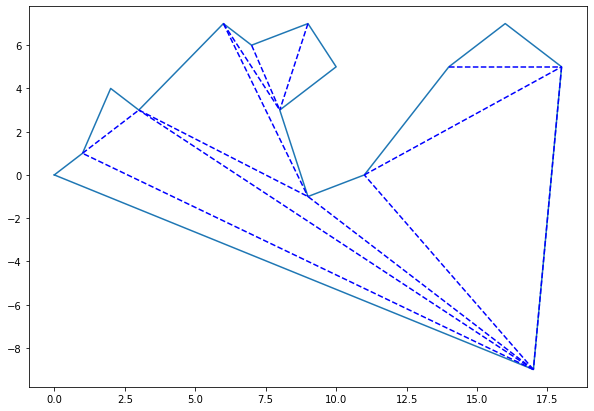

In [19]:
# Create triangulation
times = 1
for i in range(times):
    triangulated_polygon = TriangulatedPolygon(polygon)
    triangulated_polygon.triangulate()
    # triangulated_polygon.print_triangulation()
    visualize()

In [20]:
# create edges
edges = []
for edge in triangulated_polygon.triangulated_vertices:
    edges.append((edge[0], edge[1]))
    edges.append((edge[0], edge[2]))
    edges.append((edge[1], edge[2]))
    
graph_colors = ['red', 'blue', 'green']

network = ColoredNetwork(triangulated_polygon.polygon.vertices, edges, graph_colors)

In [21]:
network.color()

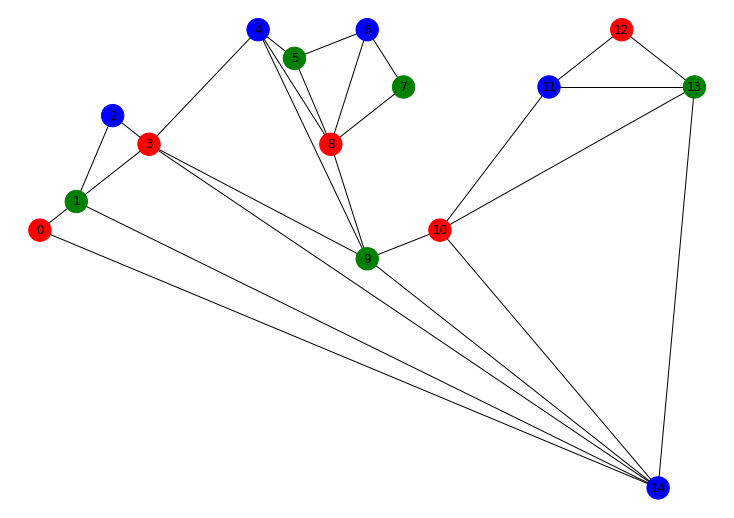

In [22]:
network.draw()

In [369]:
network.node_color_map

{0: 'red',
 14: 'blue',
 1: 'green',
 3: 'red',
 2: 'blue',
 9: 'green',
 8: 'blue',
 6: 'green',
 7: 'red',
 5: 'blue',
 4: 'green',
 10: 'red',
 11: 'green',
 13: 'red',
 12: 'blue'}